In [39]:
# !unzip /content/Test.zip

In [40]:
# !git clone https://github.com/nataliacampiglia/ml-ia-obligatorio.git
# %cd ml-ia-obligatorio
# !git pull
# !git checkout main

In [41]:
# Test Path
testPath = 'Test'

# In colob testPath is
# testPath = 'content/Test'

In [42]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from itertools import chain
from sklearn.metrics import accuracy_score  # or f1_score, etc.
from sklearn.metrics import classification_report

In [43]:
from utils import create_images_list
from pca_helper import prepare_data, process_test_images

In [44]:
suffix = '.pgm'
kaggle_files = os.listdir(testPath)
pgm_kaggle_files = [filename for filename in kaggle_files if filename.endswith(suffix)]

In [45]:
len(pgm_kaggle_files)

8000

In [46]:
kaggle_patches = []
for filename in tqdm(pgm_kaggle_files):
  path = testPath + '/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  kaggle_patches.append(image)

100%|██████████| 8000/8000 [00:02<00:00, 3741.40it/s]


In [47]:
pgm_kaggle_files_id = []

for filename in tqdm(pgm_kaggle_files):
  pgm_kaggle_files_id.append(filename[5:-4])

100%|██████████| 8000/8000 [00:00<00:00, 2431480.58it/s]


# Preprocesamiento de los datos

Obtenemos Faces y backgorunds

In [48]:
facesPath = 'Faces' # use '/content/Faces' on colab
faces = create_images_list([facesPath])
faces.shape

100%|██████████| 12833/12833 [00:03<00:00, 3997.00it/s]


(12833, 64, 64)

In [49]:
from constants import (BACKGROUND_PATH)
backgrounds = create_images_list([BACKGROUND_PATH])
backgrounds.shape


100%|██████████| 64000/64000 [00:14<00:00, 4450.98it/s]


(64000, 64, 64)

# PCA

In [ ]:
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42, use_hog=False)

Construyendo X: 25633it [00:00, 460023.68it/s]


In [ ]:
# print shape of X_train_pca, X_test, y_train, y_test, scaler, pca
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"scaler shape: {scaler}")
print(f"pca shape: {pca}")

X_train_pca shape: (17943, 500)
X_test shape: (7690, 4096)
y_train shape: (17943,)
y_test shape: (7690,)
scaler shape: StandardScaler()
pca shape: PCA(n_components=500)


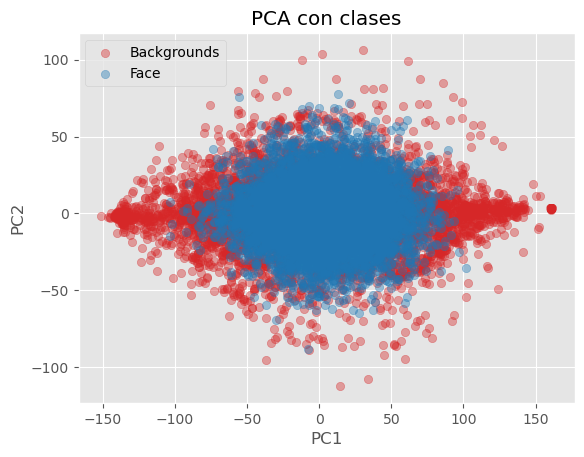

In [ ]:
# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Backgrounds', 'Face']

for class_value in [0, 1]:
    plt.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.4
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
gaussianModel = GaussianNB()
gaussianModel.fit(X_train_pca, y_train)

GaussianNB()

In [ ]:
y_train_pred = gaussianModel.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.41      0.51      8990
         1.0       0.57      0.80      0.67      8953

    accuracy                           0.61     17943
   macro avg       0.62      0.61      0.59     17943
weighted avg       0.62      0.61      0.59     17943

              precision    recall  f1-score   support

         0.0       0.67      0.41      0.51      3810
         1.0       0.58      0.80      0.67      3880

    accuracy                           0.61      7690
   macro avg       0.63      0.61      0.59      7690
weighted avg       0.63      0.61      0.59      7690



In [ ]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca, use_hog=False)
# Predicción
y_kag = gaussianModel.predict(X_pca_kag)

# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:00<00:00, 373358.02it/s]


Validation Accuracy: 0.6081924577373212


In [ ]:
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)
kaggle_hat.head()

,id,target_feature
2069,0,0
2527,1,0
3030,2,1
2576,3,1
4060,4,1


In [ ]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'pca_submition'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

# Kaggle result

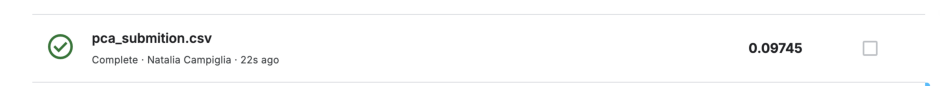

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('kaggle_submissions/pca_submition.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

# HOG

In [ ]:
# use prepare_data to get X_train_pca, X_test, y_train, y_test, scaler, pca
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42)

Construyendo X: 25633it [00:13, 1880.86it/s]


In [ ]:
# print shape of X_train_pca, X_test, y_train, y_test, scaler, pca
print(f"X_train_pca shape: {X_train_pca.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"scaler shape: {scaler}")
print(f"pca shape: {pca}")

X_train_pca shape: (17943, 500)
X_test shape: (7690, 2916)
y_train shape: (17943,)
y_test shape: (7690,)
scaler shape: StandardScaler()
pca shape: PCA(n_components=500)


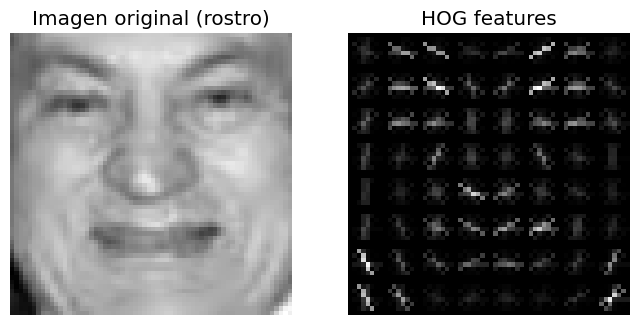

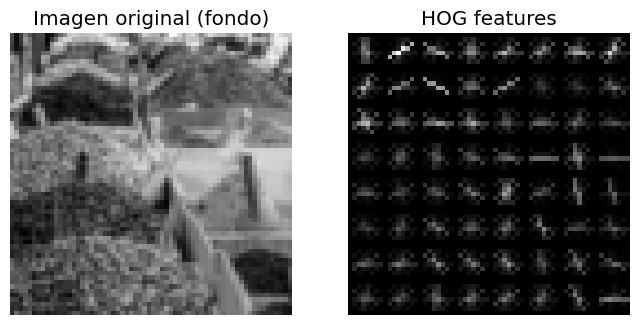

In [ ]:
# Ejemplo con una imagen de rostro
hog_features, hog_image = feature.hog(faces[0], visualize=True)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(faces[0], cmap='gray')
plt.title('Imagen original (rostro)')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG features')
plt.axis('off')
plt.show()

# Ejemplo con una imagen de rostro
hog_features, hog_image = feature.hog(backgrounds[0], visualize=True)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(backgrounds[0], cmap='gray')
plt.title('Imagen original (fondo)')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG features')
plt.axis('off')
plt.show()

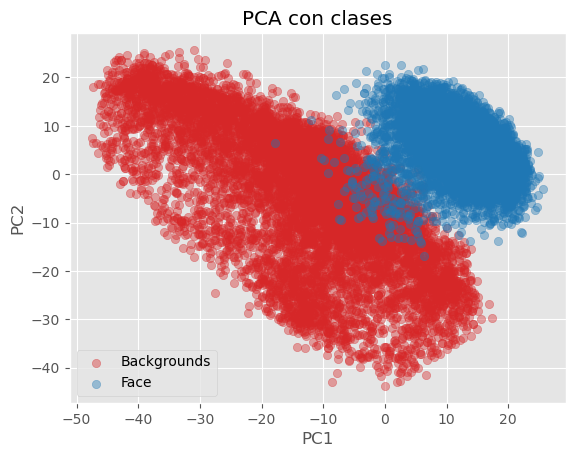

In [ ]:
# Graficar con colores y leyenda
colors = ['tab:red', 'tab:blue']
labels = ['Backgrounds', 'Face']

for class_value in [0, 1]:
    plt.scatter(
        X_train_pca[y_train == class_value, 0],
        X_train_pca[y_train == class_value, 1],
        c=colors[class_value],
        label=labels[class_value],
        alpha=0.4
    )

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA con clases')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
gaussianModel = GaussianNB()
gaussianModel.fit(X_train_pca, y_train)
y_train_pred = gaussianModel.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      8990
         1.0       0.97      0.94      0.96      8953

    accuracy                           0.96     17943
   macro avg       0.96      0.96      0.96     17943
weighted avg       0.96      0.96      0.96     17943

              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      3810
         1.0       0.98      0.93      0.95      3880

    accuracy                           0.95      7690
   macro avg       0.96      0.95      0.95      7690
weighted avg       0.96      0.95      0.95      7690



In [ ]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)
# Predicción
y_kag = gaussianModel.predict(X_pca_kag)

# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = gaussianModel.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:04<00:00, 1906.13it/s]


Validation Accuracy: 0.9547464239271781


In [ ]:
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)
kaggle_hat.head()

,id,target_feature
2069,0,0
2527,1,0
3030,2,0
2576,3,0
4060,4,0


In [ ]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'hog_submition'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

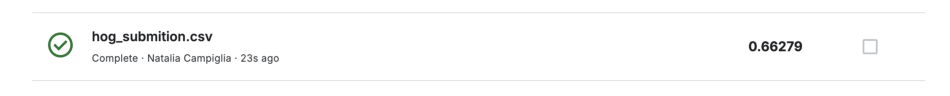

In [ ]:
import matplotlib.pyplot as plt

img = plt.imread('kaggle_submissions/hog_submission.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()

# Models

In [50]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

def compute_metrics(y_true, y_pred_probs, threshold=0.5, model_name="Model", training_time=None):
    # Umbral para clases
    y_pred_classes = (y_pred_probs > threshold).astype(int).flatten()

    # Matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_classes).ravel()

    # TPR, FPR
    TPR = tp / (tp + fn)
    FPR = fp / (fp + tn)
    TNR = tn / (tn + fp)
    GMean = np.sqrt(TPR * TNR)

    # ROC curve & AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Reporte
    print(f"\n=== {model_name} ===")
    print(f"TPR (Recall): {TPR:.4f}")
    print(f"FPR: {FPR:.4f}")
    print(f"AUC: {roc_auc:.4f}")
    print(f"G-Mean: {GMean:.4f}")
    if training_time is not None:
        print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

    # Graficar curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    return {
        "TPR": TPR,
        "FPR": FPR,
        "AUC": roc_auc,
        "GMean": GMean,
        "TrainingTime": training_time
    }


In [51]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report

In [52]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Random Forest

Random Forest es una excelente elección para este problema de clasificación de imágenes por varias razones:

1. **Manejo de Dimensionalidad**:
   - Después de aplicar PCA, nuestros datos siguen teniendo 500 dimensiones
   - Random Forest maneja bien datos de alta dimensionalidad sin necesidad de normalización adicional
   - Cada árbol en el bosque puede seleccionar diferentes subconjuntos de características

2. **Robustez**:
   - Es menos propenso al overfitting que modelos individuales
   - La combinación de múltiples árboles reduce la varianza
   - Maneja bien el ruido en los datos de imágenes

3. **Características no lineales**:
   - Puede capturar relaciones no lineales entre características
   - Importante para reconocimiento de patrones en imágenes
   - No requiere transformaciones adicionales de los datos

4. **Interpretabilidad**:
   - Proporciona importancia de características
   - Permite entender qué aspectos de las imágenes son más relevantes
   - Útil para análisis y mejoras del modelo

5. **Rendimiento**:
   - Como vemos en los resultados, alcanza una precisión del 98% en el conjunto de validación
   - Buen balance entre precisión y recall para ambas clases
   - F1-score de 0.98 indica un buen equilibrio entre precisión y recall

6. **Eficiencia computacional**:
   - Entrenamiento paralelizable
   - Predicciones rápidas
   - Escalable a grandes conjuntos de datos

7. **Manejo de desbalanceo**:
   - Puede manejar clases desbalanceadas
   - Útil si las clases de imágenes no están perfectamente balanceadas
   - Permite ajustar pesos de clases si es necesario

In [53]:
X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(faces, backgrounds, test_size=0.3, random_state=42)

Construyendo X: 76833it [01:14, 1027.63it/s]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define el modelo base
rf = RandomForestClassifier(random_state=42)
# Define la grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 15, 30],
    'max_features': ['sqrt', 'log2']
}

# Configura GridSearchCV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',   # o 'accuracy'
    n_jobs=-1,
    verbose=2
)

# Entrena
grid_rf.fit(X_train_pca, y_train)

print("Mejores hiperparámetros:", grid_rf.best_params_)
print("Mejor AUC (CV):", grid_rf.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=  28.2s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=  28.8s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=  29.1s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=  30.1s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=50; total time=  30.6s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=  56.8s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=  56.9s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time= 1.0min
[CV] END .max_depth=None, max_features=log2, n_estimators=50; total time=  12.9s
[CV] END max_depth=None, max_features=sqrt, n_estimators=100; total time=  56.9s
[CV] END .max_depth=None, max_features=log2, n_estimators=50; total time=  12.9s
[CV] END max_depth=None, max_features=sqrt, n_es

In [ ]:
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

# Predice en test con el mejor modelo
y_pred_rf = grid_rf.predict(X_test_pca)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      3810
         1.0       1.00      0.97      0.98      3880

    accuracy                           0.98      7690
   macro avg       0.98      0.98      0.98      7690
weighted avg       0.98      0.98      0.98      7690



In [ ]:
cv_results = pd.DataFrame(grid_rf.cv_results_)

In [ ]:
print(cv_results.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


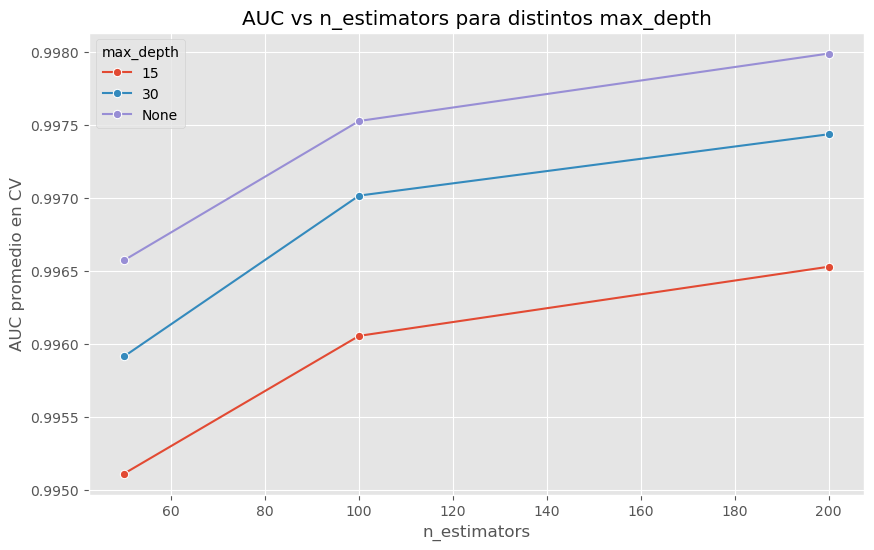

In [ ]:
# Agrupa por n_estimators y max_depth
cv_results['param_max_depth'] = cv_results['param_max_depth'].astype(str)

grouped = cv_results.groupby(['param_n_estimators', 'param_max_depth']).mean_test_score.mean().reset_index()

# Plot
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
    data=grouped,
    x='param_n_estimators',
    y='mean_test_score',
    hue='param_max_depth',
    marker='o'
)
plt.xlabel('n_estimators')
plt.ylabel('AUC promedio en CV')
plt.title('AUC vs n_estimators para distintos max_depth')
plt.legend(title='max_depth')
plt.grid(True)
plt.show()

In [19]:
# Aquí debe utilizar su modelo
from sklearn.ensemble import RandomForestClassifier
import time

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
start_time = time.time()
rf_model.fit(X_train_pca, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

Tiempo de entrenamiento: 504.84 segundos


In [22]:
y_train_pred = rf_model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = rf_model.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     44795
         1.0       1.00      1.00      1.00      8988

    accuracy                           1.00     53783
   macro avg       1.00      1.00      1.00     53783
weighted avg       1.00      1.00      1.00     53783

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     19205
         1.0       1.00      0.92      0.96      3845

    accuracy                           0.99     23050
   macro avg       0.99      0.96      0.97     23050
weighted avg       0.99      0.99      0.99     23050




=== Random Forest ===
TPR (Recall): 0.9152
FPR: 0.0000
AUC: 0.9981
G-Mean: 0.9567
Tiempo de entrenamiento: 504.84 segundos


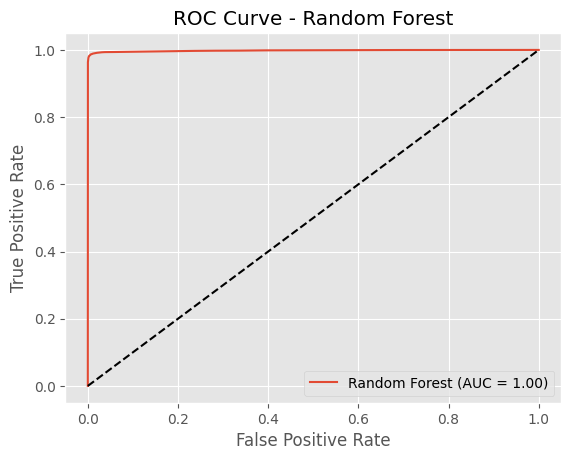

In [24]:
# Suponiendo que tienes probabilidades:
y_rf_probs = rf_model.predict_proba(X_test_pca)[:, 1]

metrics_rf = compute_metrics(y_test, y_rf_probs, model_name="Random Forest", training_time=training_time)

In [17]:
# Aquí debe procesar las imagenes de pgm_kaggle_files
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:12<00:00, 653.83it/s]


In [ ]:
# Predicción
y_kag = rf_model.predict(X_pca_kag)

In [ ]:
# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = rf_model.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)


Validation Accuracy: 0.9845253576072822


In [ ]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

In [ ]:
kaggle_hat.head()

,id,target_feature
2069,0,0
2527,1,0
3030,2,0
2576,3,0
4060,4,0


In [ ]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'submission_RandomForestClassifier'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

In [ ]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)
y_kag = rf_model.predict(X_pca_kag)
# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = rf_model.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

kaggle_hat.head()

# Guardamos en un .csv para subir a kaggle
submission_name = 'submission_RandomForestClassifier'
kaggle_hat.to_csv(submission_name + '.csv', index=False)


Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:04<00:00, 1946.47it/s]


Validation Accuracy: 0.9845253576072822


### Baggin

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

In [ ]:
# Árbol de decisión simple como base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Metaestimador Bagging
bagging = BaggingClassifier(
    estimator=base_estimator,
    random_state=42
)

In [ ]:
param_grid_bagging = {
    'n_estimators': [50, 100],
    'estimator__max_depth': [10, None],  # max_depth del árbol base
    'bootstrap': [True, False]
}

In [ ]:
grid_bagging = GridSearchCV(
    estimator=bagging,
    param_grid=param_grid_bagging,
    cv=cv,
    scoring='roc_auc',   # o 'accuracy'
    n_jobs=-1,
    verbose=2
)

grid_bagging.fit(X_train_pca, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.3min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.3min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.3min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.3min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=50; total time= 5.4min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=100; total time=10.8min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=100; total time=10.8min
[CV] END bootstrap=True, estimator__max_depth=10, n_estimators=100; total time=11.0min
[CV] END bootstrap=True, estimator__max_depth=None, n_estimators=50; total time= 7.3min
[CV] END bootstrap=True, estimator__max_depth=None, n_estimators=50; total time= 7.6min
[CV] END bootstrap=True, estimator__max_depth=None, n_estimators=50; tota

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'estimator__max_depth': [10, None],
                         'n_estimators': [50, 100]},
             scoring='roc_auc', verbose=2)

In [ ]:
print("Mejores hiperparámetros:", grid_bagging.best_params_)
print("Mejor AUC (CV):", grid_bagging.best_score_)

Mejores hiperparámetros: {'bootstrap': True, 'estimator__max_depth': 10, 'n_estimators': 100}
Mejor AUC (CV): 0.9977275847083339


In [ ]:
print("Mejores hiperparámetros:", grid_bagging.best_params_)
print("Mejor AUC (CV):", grid_bagging.best_score_)

scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)


# Predicción final en test
y_pred_bagging = grid_bagging.predict(X_test_pca)
print(classification_report(y_test, y_pred_bagging))

Mejores hiperparámetros: {'bootstrap': True, 'estimator__max_depth': 10, 'n_estimators': 100}
Mejor AUC (CV): 0.9977275847083339
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3810
         1.0       0.99      0.98      0.99      3880

    accuracy                           0.99      7690
   macro avg       0.99      0.99      0.99      7690
weighted avg       0.99      0.99      0.99      7690



In [ ]:
baggin_cv_results = pd.DataFrame(grid_bagging.cv_results_)
print(baggin_cv_results.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_bootstrap', 'param_estimator__max_depth', 'param_n_estimators',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')


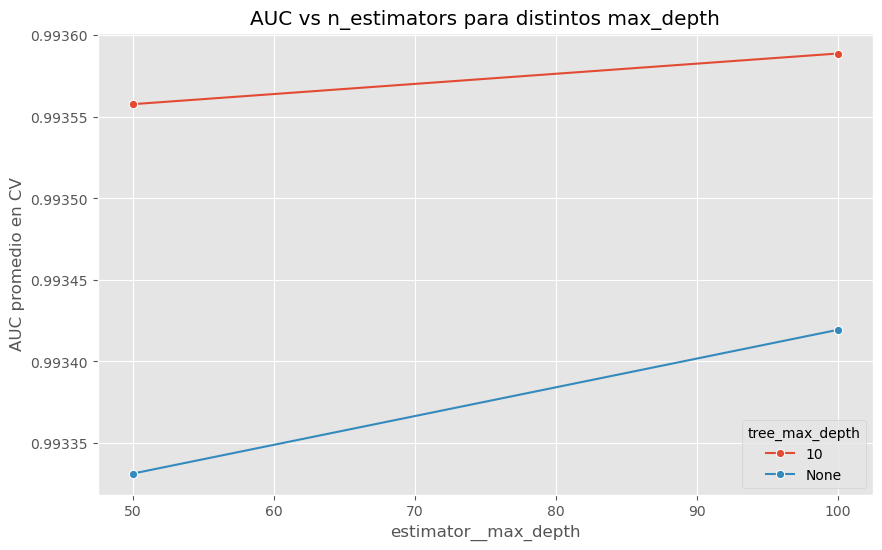

In [ ]:
# Agrupa por n_estimators y max_depth
baggin_cv_results['param_estimator__max_depth'] = baggin_cv_results['param_estimator__max_depth'].astype(str)

grouped = baggin_cv_results.groupby(['param_n_estimators', 'param_estimator__max_depth']).mean_test_score.mean().reset_index()

# Plot
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(
    data=grouped,
    x='param_n_estimators',
    y='mean_test_score',
    hue='param_estimator__max_depth',
    marker='o'
)
plt.xlabel('estimator__max_depth')
plt.ylabel('AUC promedio en CV')
plt.title('AUC vs n_estimators para distintos max_depth')
plt.legend(title='tree_max_depth')
plt.grid(True)
plt.show()

In [27]:
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),
    bootstrap=True,
    n_estimators=100,
)

start_time = time.time()
bagging_model.fit(X_train_pca, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")


Tiempo de entrenamiento: 3358.46 segundos


In [28]:
y_train_pred = bagging_model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = bagging_model.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     44795
         1.0       1.00      0.98      0.99      8988

    accuracy                           1.00     53783
   macro avg       1.00      0.99      0.99     53783
weighted avg       1.00      1.00      1.00     53783

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     19205
         1.0       1.00      0.97      0.98      3845

    accuracy                           0.99     23050
   macro avg       0.99      0.98      0.99     23050
weighted avg       0.99      0.99      0.99     23050



In [29]:
# Aquí debe procesar las imagenes de pgm_kaggle_files
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:12<00:00, 652.45it/s]


In [30]:
y_kag = bagging_model.predict(X_pca_kag)

In [31]:
# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = bagging_model.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Validation Accuracy: 0.9937093275488069



=== Bagging ===
TPR (Recall): 0.9659
FPR: 0.0007
AUC: 0.9965
G-Mean: 0.9825
Tiempo de entrenamiento: 3358.46 segundos


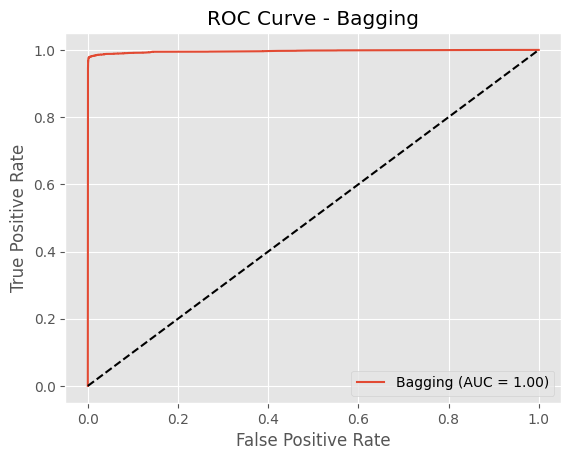

In [32]:
y_bagging_probs = bagging_model.predict_proba(X_test_pca)[:, 1]

metrics_bagging = compute_metrics(y_test, y_bagging_probs, model_name="Bagging", training_time=training_time)


In [ ]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

In [ ]:
kaggle_hat.head()

In [ ]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'submission_BaggingClassifier'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

# Boosting

In [54]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:


# Prepara tus datos igual que para Bagging y RF
# X_train_pca, X_test, y_train, y_test, scaler, pca = prepare_data(...)

# Configura CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo base para AdaBoost
base_estimator = DecisionTreeClassifier(random_state=42)

ada = AdaBoostClassifier(
    estimator=base_estimator,
    random_state=42
)

# Grilla de hiperparámetros
param_grid_ada = {
    'n_estimators': [150],
    'learning_rate': [0.5, 1.0, 1.5],
    'estimator__max_depth': [2, 3, 5]
}

# GridSearchCV
grid_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    cv=cv,
    scoring='roc_auc',  # o 'accuracy'
    n_jobs=-1,
    verbose=2
)

grid_ada.fit(X_train_pca, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=150; total time=45.4min
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=150; total time=45.5min
[CV] END estimator__max_depth=2, learning_rate=1.0, n_estimators=150; total time=45.5min
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=150; total time=45.6min
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=150; total time=45.6min
[CV] END estimator__max_depth=2, learning_rate=1.0, n_estimators=150; total time=45.6min
[CV] END estimator__max_depth=2, learning_rate=1.0, n_estimators=150; total time=45.7min
[CV] END estimator__max_depth=2, learning_rate=0.5, n_estimators=150; total time=45.8min
[CV] END estimator__max_depth=2, learning_rate=1.5, n_estimators=150; total time=38.7min
[CV] END estimator__max_depth=2, learning_rate=1.0, n_estimators=150; total time=38.8min
[CV] END estimator__max_depth=2, learning_rate=1.0, n_estimators=150; total time=38.8min
[CV] END estimator__m

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [2, 3, 5],
                         'learning_rate': [0.5, 1.0, 1.5],
                         'n_estimators': [150]},
             scoring='roc_auc', verbose=2)

In [56]:

print("Mejores hiperparámetros:", grid_ada.best_params_)
print("Mejor AUC (CV):", grid_ada.best_score_)

# Evalúa en test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_pred_ada = grid_ada.predict(X_test_pca)
print(classification_report(y_test, y_pred_ada))

# Visualiza resultados
b_cv_results = pd.DataFrame(grid_ada.cv_results_)

print(b_cv_results.columns)


Mejores hiperparámetros: {'estimator__max_depth': 5, 'learning_rate': 1.0, 'n_estimators': 150}
Mejor AUC (CV): 0.9997594248806783
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19205
         1.0       1.00      0.98      0.99      3845

    accuracy                           1.00     23050
   macro avg       1.00      0.99      1.00     23050
weighted avg       1.00      1.00      1.00     23050

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_estimator__max_depth', 'param_learning_rate',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


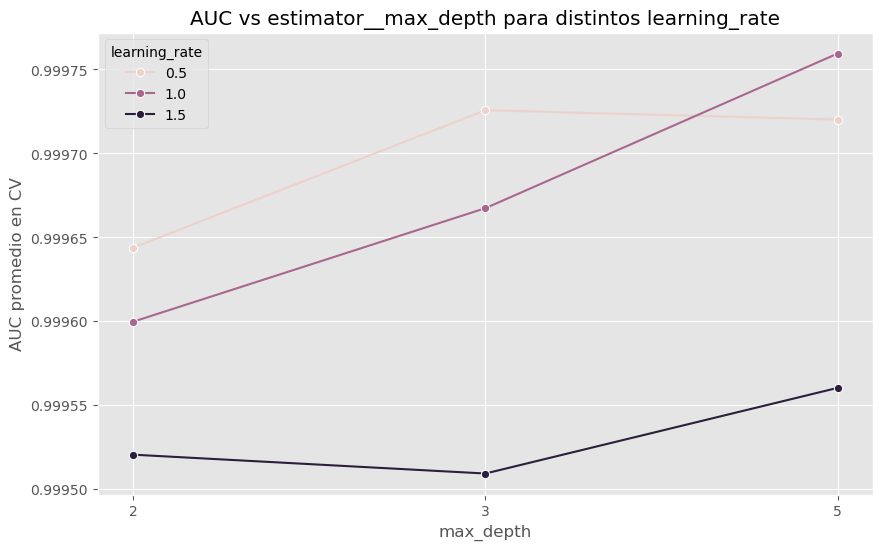

In [57]:

b_cv_results['param_estimator__max_depth'] = b_cv_results['param_estimator__max_depth'].astype(str)

grouped = b_cv_results.groupby(['param_estimator__max_depth', 'param_learning_rate']).mean_test_score.mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(
    data=grouped,
    x='param_estimator__max_depth',
    y='mean_test_score',
    hue='param_learning_rate',
    marker='o'
)
plt.xlabel('max_depth')
plt.ylabel('AUC promedio en CV')
plt.title('AUC vs estimator__max_depth para distintos learning_rate')
plt.legend(title='learning_rate')
plt.grid(True)
plt.show()


In [ ]:

# Grilla de hiperparámetros
param_grid_ada = {
    'n_estimators': [150],
    'learning_rate': [1.0],
    'estimator__max_depth': [3, 10]
}

# GridSearchCV
grid_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    cv=cv,
    scoring='roc_auc',  # o 'accuracy'
    n_jobs=-1,
    verbose=2
)

grid_ada.fit(X_train_pca, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END estimator__max_depth=3, learning_rate=1.0, n_estimators=150; total time=15.6min
[CV] END estimator__max_depth=3, learning_rate=1.0, n_estimators=150; total time=15.6min
[CV] END estimator__max_depth=3, learning_rate=1.0, n_estimators=150; total time=15.6min
[CV] END estimator__max_depth=3, learning_rate=1.0, n_estimators=150; total time=15.6min
[CV] END estimator__max_depth=3, learning_rate=1.0, n_estimators=150; total time=15.7min
[CV] END estimator__max_depth=10, learning_rate=1.0, n_estimators=150; total time=39.9min
[CV] END estimator__max_depth=10, learning_rate=1.0, n_estimators=150; total time=40.2min
[CV] END estimator__max_depth=10, learning_rate=1.0, n_estimators=150; total time=40.4min
[CV] END estimator__max_depth=10, learning_rate=1.0, n_estimators=150; total time=33.3min
[CV] END estimator__max_depth=10, learning_rate=1.0, n_estimators=150; total time=33.3min


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [3, 10],
                         'learning_rate': [1.0], 'n_estimators': [150]},
             scoring='roc_auc', verbose=2)

In [ ]:
print("Mejores hiperparámetros:", grid_ada.best_params_)
print("Mejor AUC (CV):", grid_ada.best_score_)

#  Evalúa en test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_pred_ada = grid_ada.predict(X_test_pca)
print(classification_report(y_test, y_pred_ada))

# Visualiza resultados
b_cv_results = pd.DataFrame(grid_ada.cv_results_)

print(b_cv_results.columns)

Mejores hiperparámetros: {'estimator__max_depth': 3, 'learning_rate': 1.0, 'n_estimators': 150}
Mejor AUC (CV): 0.9996603817491643
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3810
         1.0       1.00      0.99      1.00      3880

    accuracy                           1.00      7690
   macro avg       1.00      1.00      1.00      7690
weighted avg       1.00      1.00      1.00      7690

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_estimator__max_depth', 'param_learning_rate',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


In [35]:
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3),
    learning_rate=1,
    n_estimators=150,
)

start_time = time.time()
ada_model.fit(X_train_pca, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")


Tiempo de entrenamiento: 2796.26 segundos


In [47]:
y_train_pred = ada_model.predict(X_train_pca)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = ada_model.predict(X_test_pca)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     44795
         1.0       1.00      1.00      1.00      8988

    accuracy                           1.00     53783
   macro avg       1.00      1.00      1.00     53783
weighted avg       1.00      1.00      1.00     53783

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19205
         1.0       1.00      0.98      0.99      3845

    accuracy                           1.00     23050
   macro avg       1.00      0.99      0.99     23050
weighted avg       1.00      1.00      1.00     23050



In [48]:
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:12<00:00, 658.88it/s]


In [49]:
y_kag = ada_model.predict(X_pca_kag)

In [50]:
# Evaluate
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = ada_model.predict(X_test_pca)
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

Validation Accuracy: 0.9970932754880694



=== Boosting ===
TPR (Recall): 0.9836
FPR: 0.0002
AUC: 0.9996
G-Mean: 0.9917
Tiempo de entrenamiento: 2796.26 segundos


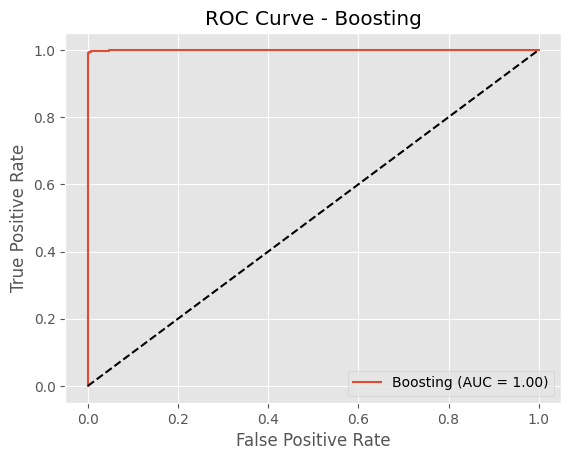

In [51]:
y_boosting_probs = ada_model.predict_proba(X_test_pca)[:, 1]

metrics_boosting = compute_metrics(y_test, y_boosting_probs, model_name="Boosting", training_time=training_time)

In [52]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

kaggle_hat.head()



,id,target_feature
4751,0,0
6325,1,0
7608,2,0
309,3,0
6151,4,0


In [53]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'submission_AdaBoost_Classifier'
kaggle_hat.to_csv(submission_name + '.csv', index=False)

# Redes Neuronales

In [54]:
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define la red neuronal
rn_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_pca.shape[1],)),  # Capa oculta 1
    layers.Dense(32, activation='relu'),  # Capa oculta 2
    layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

# Compila
rn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Clave: para clasificación binaria
    metrics=['accuracy']
)

# Entrena
start_time = time.time()
history = rn_model.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    epochs=50,
    batch_size=32
)
end_time = time.time()
training_time = end_time - start_time

# Evalúa
loss, accuracy = rn_model.evaluate(X_test_pca, y_test)
print(f"Test accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9852 - loss: 0.0421 - val_accuracy: 0.9968 - val_loss: 0.0119
Epoch 2/50
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9990 - loss: 0.0030 - val_accuracy: 0.9973 - val_loss: 0.0120
Epoch 3/50
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9998 - loss: 8.5160e-04 - val_accuracy: 0.9971 - val_loss: 0.0119
Epoch 4/50
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9976 - val_loss: 0.0157
Epoch 5/50
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9977 - val_loss: 0.0116
Epoch 6/50
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9999 - loss: 4.0500e-04 - val_accuracy: 0.9981 - val_loss: 0.0130
Epoch 7/50
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 1.3157e-05 - val_accuracy: 0.9982 - val_loss: 0.0135
Epoch 8/50
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - los

In [56]:
y_train_pred = (rn_model.predict(X_train_pca) > 0.5).astype(int)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = (rn_model.predict(X_test_pca) > 0.5).astype(int)

print(classification_report(y_test, y_test_pred))

1681/1681 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     44795
         1.0       1.00      1.00      1.00      8988

    accuracy                           1.00     53783
   macro avg       1.00      1.00      1.00     53783
weighted avg       1.00      1.00      1.00     53783

721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19205
         1.0       1.00      0.99      0.99      3845

    accuracy                           1.00     23050
   macro avg       1.00      1.00      1.00     23050
weighted avg       1.00      1.00      1.00     23050



In [57]:
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

=== Red Neuronal ===
TPR (Recall): 0.9925
FPR: 0.0005
AUC: 0.9998
G-Mean: 0.9960
Tiempo de entrenamiento: 325.84 segundos


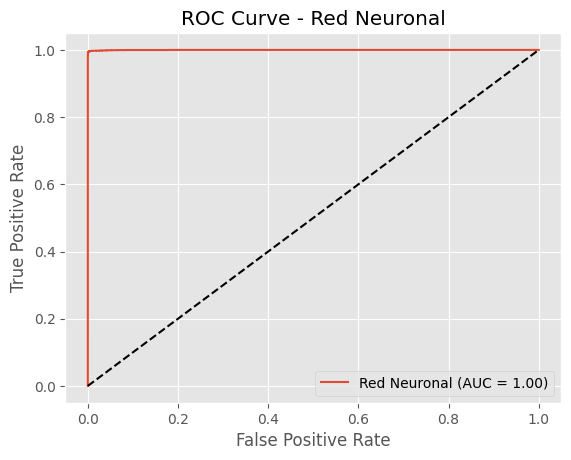

In [58]:
y_nn_probs = rn_model.predict(X_test_pca)  # Ya da probas
metrics_nn = compute_metrics(y_test, y_nn_probs, model_name="Red Neuronal", training_time=training_time)

In [59]:
# Preprocesar test para Kaggle
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

# Predicciones con la red neuronal
y_kag_probs = rn_model.predict(X_pca_kag)
y_kag = (y_kag_probs > 0.5).astype(int).flatten()


Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:11<00:00, 669.50it/s]


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [60]:
#  (Opcional) Evalúa en tu test interno para comparar
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)
y_test_probs = rn_model.predict(X_test_pca)
y_test_pred = (y_test_probs > 0.5).astype(int).flatten()

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)



721/721 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Validation Accuracy: 0.9983080260303687


In [61]:
#  Combina ID + predicción
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)


In [62]:
kaggle_hat.head()

,id,target_feature
4751,0,0
6325,1,0
7608,2,0
309,3,0
6151,4,0


In [63]:
# Guarda CSV para Kaggle
submission_name = 'submission_NeuralNetwork'
kaggle_hat.to_csv(submission_name + '.csv', index=False)
print(f"Archivo {submission_name}.csv listo para subir a Kaggle ")

Archivo submission_NeuralNetwork.csv listo para subir a Kaggle 🚀


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Modelo
rn_model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_pca.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
rn_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenamiento
history = rn_model.fit(
    X_train_pca, y_train,
    validation_data=(X_test_pca, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop]
)

# Evaluación
loss, accuracy, auc = rn_model.evaluate(X_test_pca, y_test)
print(f"Test accuracy: {accuracy:.4f}, Test AUC: {auc:.4f}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8572 - auc: 0.9128 - loss: 0.3322 - val_accuracy: 0.9954 - val_auc: 0.9995 - val_loss: 0.0178
Epoch 2/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9928 - auc: 0.9991 - loss: 0.0230 - val_accuracy: 0.9966 - val_auc: 0.9995 - val_loss: 0.0148
Epoch 3/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9960 - auc: 0.9997 - loss: 0.0125 - val_accuracy: 0.9957 - val_auc: 0.9990 - val_loss: 0.0164
Epoch 4/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9970 - auc: 0.9999 - loss: 0.0091 - val_accuracy: 0.9960 - val_auc: 0.9994 - val_loss: 0.0140
Epoch 5/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.0030 - val_accuracy: 0.9964 - val_auc: 0.9988 - val_loss: 0.0164
Epoch 6/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9993 - auc: 1.0000 - loss: 0.0020 - val_accuracy: 0.9960 - val_auc: 0.9987 - val_loss: 0.0185
Epoch 7/100
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s

In [ ]:
_train_pred = (rn_model.predict(X_train_pca) > 0.5).astype(int)
print(classification_report(y_train, y_train_pred))

# Estandarizar y transformar datos de test
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

y_test_pred = (rn_model.predict(X_test_pca) > 0.5).astype(int)

print(classification_report(y_test, y_test_pred))

561/561 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8990
         1.0       1.00      1.00      1.00      8953

    accuracy                           1.00     17943
   macro avg       1.00      1.00      1.00     17943
weighted avg       1.00      1.00      1.00     17943

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3810
         1.0       1.00      0.99      1.00      3880

    accuracy                           1.00      7690
   macro avg       1.00      1.00      1.00      7690
weighted avg       1.00      1.00      1.00      7690



In [ ]:
scaler = StandardScaler()
X_test_std = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_std)

241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== Red Neuronal ===
TPR (Recall): 0.9948
FPR: 0.0029
AUC: 0.9998
G-Mean: 0.9960


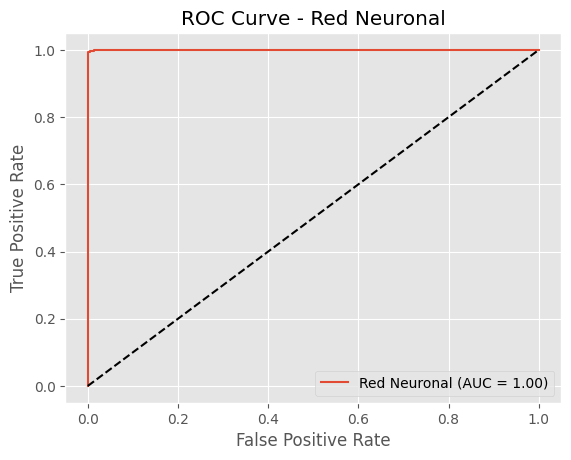

In [ ]:
y_nn_probs = rn_model.predict(X_test_pca)  # Ya da probas
metrics_nn = compute_metrics(y_test, y_nn_probs, model_name="Red Neuronal")

In [ ]:
#  Preprocesar test para Kaggle
X_pca_kag = process_test_images(kaggle_patches, scaler, pca)

# Predicciones con la red neuronal
y_kag_probs = rn_model.predict(X_pca_kag)
y_kag = (y_kag_probs > 0.5).astype(int).flatten()

Procesando imágenes de prueba: 100%|██████████| 8000/8000 [00:18<00:00, 425.17it/s]


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
# (Opcional) Evalúa en tu test interno para comparar
X_test_std = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_std)
y_test_probs = rn_model.predict(X_test_pca)
y_test_pred = (y_test_probs > 0.5).astype(int).flatten()

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", score)

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation Accuracy: 0.9959687906371911


In [ ]:
# Combina ID + predicción
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)


In [ ]:
kaggle_hat.head()

,id,target_feature
1379,0,0
7084,1,0
5414,2,0
2021,3,0
4396,4,0


In [ ]:
# Guarda CSV para Kaggle
submission_name = 'submission_NeuralNetwork_earlystopping'
kaggle_hat.to_csv(submission_name + '.csv', index=False)
print(f"Archivo {submission_name}.csv listo para subir a Kaggle 🚀")

Archivo submission_NeuralNetwork_earlystopping.csv listo para subir a Kaggle 🚀


# Evaluacion de modelos

In [64]:
results = pd.DataFrame([
    {"Model": "Random Forest", **metrics_rf},
    {"Model": "Bagging", **metrics_bagging},
    {"Model": "Boosting", **metrics_boosting},
    {"Model": "Red Neuronal", **metrics_nn},

])
results = results.round(4)
results

,Model,TPR,FPR,AUC,GMean,TrainingTime
0,Random Forest,0.9152,0.0000,0.9981,0.9567,504.8419
1,Bagging,0.9659,0.0007,0.9965,0.9825,3358.4592
2,Boosting,0.9836,0.0002,0.9996,0.9917,2796.2570
3,Red Neuronal,0.9925,0.0005,0.9998,0.9960,325.8412


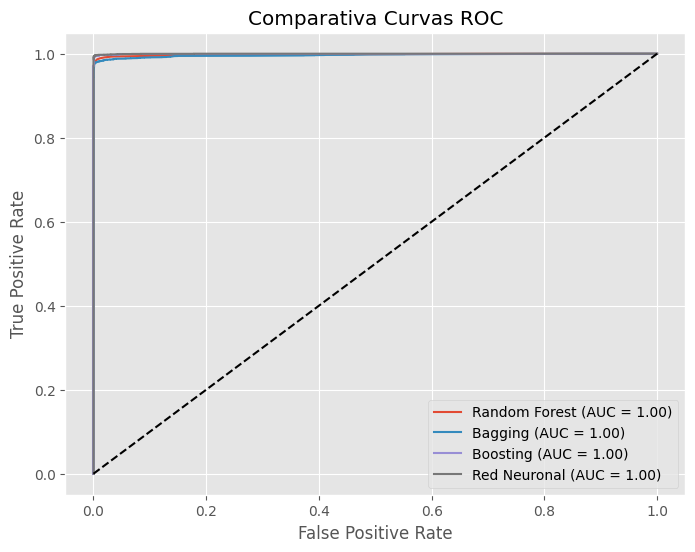

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_rf_probs)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {metrics_rf['AUC']:.2f})")

# Bagging
fpr_bag, tpr_bag, _ = roc_curve(y_test, y_bagging_probs)
plt.plot(fpr_bag, tpr_bag, label=f"Bagging (AUC = {metrics_bagging['AUC']:.2f})")

#Boosting
fpr_boost, tpr_boost, _ = roc_curve(y_test, y_boosting_probs)
plt.plot(fpr_boost, tpr_boost, label=f"Boosting (AUC = {metrics_boosting['AUC']:.2f})")

# Red Neuronal
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_nn_probs)
plt.plot(fpr_nn, tpr_nn, label=f"Red Neuronal (AUC = {metrics_nn['AUC']:.2f})")

# Línea diagonal
plt.plot([0,1], [0,1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparativa Curvas ROC')
plt.legend(loc='lower right')
plt.show()

In [66]:
print(results.columns.tolist())

['Model', 'TPR', 'FPR', 'AUC', 'GMean', 'TrainingTime']


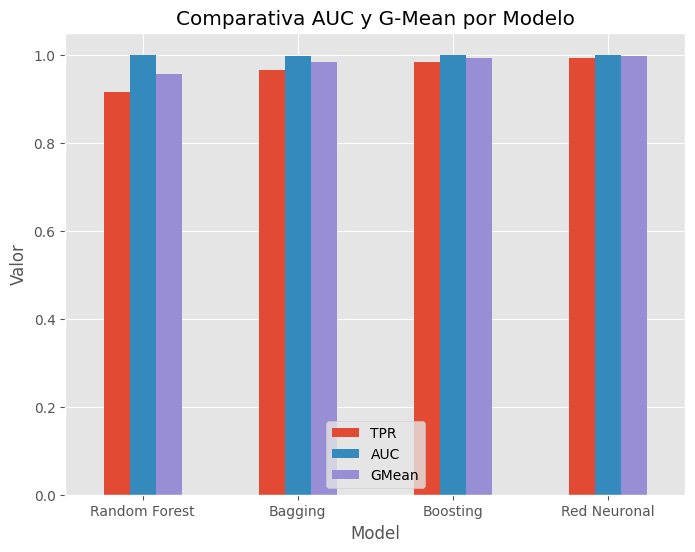

In [68]:
results.plot(x='Model', y=['TPR','AUC', 'GMean'], kind='bar', figsize=(8,6))
plt.title('Comparativa AUC y G-Mean por Modelo')
plt.ylabel('Valor')
plt.xticks(rotation=0)
plt.show()